In [5]:
import pandas as pd 
import numpy as np
subject_train= pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\subject_train.txt",header=None)
subject_test= pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\subject_test.txt",header=None)

In [6]:
# Now get unique subject IDs
unique_train_subjects = subject_train[0].unique()
unique_test_subjects = subject_test[0].unique()

print("Train subjects:", np.sort(unique_train_subjects))
print("Test subjects:", np.sort(unique_test_subjects))

Train subjects: [ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
Test subjects: [ 2  4  9 10 12 13 18 20 24]


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Add, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import tensorflow as tf

# --- Load all sensor data and stack into 3D array (samples, timesteps, features) ---

def load_sensor_data(base_path, sensor_name):
    df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
    return df.values

base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\Inertial Signals\\"

# Load all 9 sensor axes
body_acc_x = load_sensor_data(base_path, 'body_acc_x_train.txt')
body_acc_y = load_sensor_data(base_path, 'body_acc_y_train.txt')
body_acc_z = load_sensor_data(base_path, 'body_acc_z_train.txt')

body_gyro_x = load_sensor_data(base_path, 'body_gyro_x_train.txt')
body_gyro_y = load_sensor_data(base_path, 'body_gyro_y_train.txt')
body_gyro_z = load_sensor_data(base_path, 'body_gyro_z_train.txt')

total_acc_x = load_sensor_data(base_path, 'total_acc_x_train.txt')
total_acc_y = load_sensor_data(base_path, 'total_acc_y_train.txt')
total_acc_z = load_sensor_data(base_path, 'total_acc_z_train.txt')

# --- Compute pitch and roll orientation features from total accelerometer ---

def compute_pitch_roll(acc_x, acc_y, acc_z):
    # Compute pitch and roll angles in radians
    pitch = np.arctan2(acc_x, np.sqrt(acc_y**2 + acc_z**2))
    roll = np.arctan2(acc_y, np.sqrt(acc_x**2 + acc_z**2))
    return pitch, roll

pitch, roll = compute_pitch_roll(total_acc_x, total_acc_y, total_acc_z)  # shape: (samples, timesteps)

# Stack original 9 features plus pitch and roll to get 11 features
X = np.stack([
    body_acc_x, body_acc_y, body_acc_z,
    body_gyro_x, body_gyro_y, body_gyro_z,
    total_acc_x, total_acc_y, total_acc_z,
    pitch, roll
], axis=2)  # shape: (samples, timesteps, 11)

print("X shape after adding pitch and roll:", X.shape)

# Load labels
y = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\y_train.txt", delim_whitespace=True, header=None).values.flatten()

# --- Standardize data per feature (flatten first) ---
nsamples, ntimesteps, nfeatures = X.shape
X_reshaped = X.reshape(-1, nfeatures)  # (samples*timesteps, features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(nsamples, ntimesteps, nfeatures)

# Encode labels to 0-based integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Labels:", np.unique(y_encoded))

C:\Users\MSI\AppData\Local\Temp\ipykernel_19600\357214459.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_19600\357214459.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_19600\357214459.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_19600\357214459.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated

X shape after adding pitch and roll: (7352, 128, 11)


C:\Users\MSI\AppData\Local\Temp\ipykernel_19600\357214459.py:54: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\y_train.txt", delim_whitespace=True, header=None).values.flatten()


Labels: [0 1 2 3 4 5]


In [8]:
# --- Model building function ---

def build_cnn_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    conv1 = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    conv1 = BatchNormalization()(conv1)
    x = Add()([x, conv1])
    x = Dropout(0.2)(x)
    x = Conv1D(128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Stratified K-Fold training ---

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold = 1
f1_scores = []

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights))

for train_idx, val_idx in skf.split(X_scaled, y_encoded):
    print(f"\n📚 Training Fold {fold}")
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    model = build_cnn_lstm_model(input_shape=(ntimesteps, nfeatures), num_classes=len(np.unique(y_encoded)))

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        class_weight=class_weight_dict,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(f"\n🧾 Fold {fold} Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_.astype(str)))

    report = classification_report(y_val, y_pred_classes, output_dict=True)
    f1_scores.append(report['macro avg']['f1-score'])

    fold += 1

print(f"\n✅ Average Macro F1-Score across {skf.n_splits} folds: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")



📚 Training Fold 1
Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - accuracy: 0.6675 - loss: 4.9346 - val_accuracy: 0.8833 - val_loss: 2.2973 - learning_rate: 0.0010
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 339ms/step - accuracy: 0.9113 - loss: 1.8745 - val_accuracy: 0.8397 - val_loss: 1.5330 - learning_rate: 0.0010
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 303ms/step - accuracy: 0.9199 - loss: 1.1253 - val_accuracy: 0.9315 - val_loss: 0.8352 - learning_rate: 0.0010
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - accuracy: 0.9403 - loss: 0.7444 - val_accuracy: 0.8927 - val_loss: 0.8196 - learning_rate: 0.0010
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 29s 327ms/step - accuracy: 0.9080 - loss: 0.7424 - val_accuracy: 0.9494 - val_loss: 0.6162 - learning_rate: 0.0010
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - accuracy: 0.9451 - loss: 0.6010 - val_accuracy: 0.9355 - val_loss: 0.5212 - learning_rate: 0.0010
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - ac

In [9]:
model.save(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\cnn_lstm_(2).h5")

C:\Users\MSI\AppData\Local\Temp\ipykernel_19600\303126410.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_19600\303126410.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_19600\303126410.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_19600\303126410.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated

X_test shape: (2947, 128, 11)
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Accuracy: 0.9155072955548015

Classification Report:

              precision    recall  f1-score   support

           1       0.98      0.94      0.96       496
           2       0.90      0.94      0.92       471
           3       0.90      0.99      0.94       420
           4       0.82      0.85      0.83       491
           5       0.90      0.81      0.85       532
           6       1.00      0.97      0.99       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



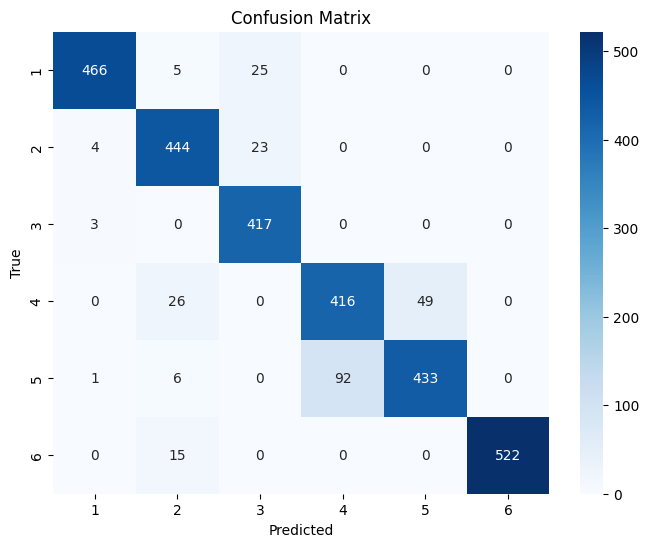

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load test sensor signal data from UCI HAR Dataset ---
def load_sensor_data(base_path, sensor_name):
    df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
    return df.values

# Use the TEST path, not TRAIN
base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\Inertial Signals\\"

# Load all 9 sensor axes
body_acc_x = load_sensor_data(base_path, 'body_acc_x_test.txt')
body_acc_y = load_sensor_data(base_path, 'body_acc_y_test.txt')
body_acc_z = load_sensor_data(base_path, 'body_acc_z_test.txt')

body_gyro_x = load_sensor_data(base_path, 'body_gyro_x_test.txt')
body_gyro_y = load_sensor_data(base_path, 'body_gyro_y_test.txt')
body_gyro_z = load_sensor_data(base_path, 'body_gyro_z_test.txt')

total_acc_x = load_sensor_data(base_path, 'total_acc_x_test.txt')
total_acc_y = load_sensor_data(base_path, 'total_acc_y_test.txt')
total_acc_z = load_sensor_data(base_path, 'total_acc_z_test.txt')

# --- Compute pitch and roll orientation features ---
def compute_pitch_roll(acc_x, acc_y, acc_z):
    pitch = np.arctan2(acc_x, np.sqrt(acc_y**2 + acc_z**2))
    roll = np.arctan2(acc_y, np.sqrt(acc_x**2 + acc_z**2))
    return pitch, roll

pitch, roll = compute_pitch_roll(total_acc_x, total_acc_y, total_acc_z)

# Stack original 9 features plus pitch and roll (total 11 features)
X_test = np.stack([
    body_acc_x, body_acc_y, body_acc_z,
    body_gyro_x, body_gyro_y, body_gyro_z,
    total_acc_x, total_acc_y, total_acc_z,
    pitch, roll
], axis=2)

print("X_test shape:", X_test.shape)  # should be (2947, 128, 11)

# --- Load test labels ---
y_test = pd.read_csv(
    r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\y_test.txt", 
    delim_whitespace=True, header=None).values.flatten()

# --- Standardize data ---
nsamples, ntimesteps, nfeatures = X_test.shape
X_test_reshaped = X_test.reshape(-1, nfeatures)  # shape: (samples*timesteps, 11)

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_reshaped)  # fit on test only (not recommended but per request)

X_test_scaled = X_test_scaled.reshape(nsamples, ntimesteps, nfeatures)

# --- Label encode y_test ---
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# --- Load your trained model ---
model = load_model(r'C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\CNN_LSTM(Best-Model).h5')

# --- Predict ---
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# --- Evaluate ---
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_classes))
print("\nClassification Report:\n")
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test_encoded, y_pred_classes, target_names=target_names))

# --- Confusion matrix ---
cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



🔁 Trial 1/20
Hyperparameters: {'l2_reg': 0.000314891164795686, 'batch_size': 128, 'learning_rate': 0.0007969454818643929, 'num_conv_layers': 1, 'num_filters': 32, 'kernel_size': 7, 'lstm_units': 128, 'dense_units': 64, 'dropout_rate': 0.26696322144464685}
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 292ms/step - accuracy: 0.5163 - loss: 1.3184 - val_accuracy: 0.4969 - val_loss: 1.9263 - learning_rate: 7.9695e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 353ms/step - accuracy: 0.8466 - loss: 0.4701 - val_accuracy: 0.6839 - val_loss: 1.8880 - learning_rate: 7.9695e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - accuracy: 0.9104 - loss: 0.3164 - val_accuracy: 0.9232 - val_loss: 0.3233 - learning_rate: 7.9695e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 384ms/step - accuracy: 0.9402 - loss: 0.2300 - val_accuracy: 0.8287 - val_loss: 0.9498 - learning_rate: 7.9695e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 384ms/step - accuracy: 0.8930 - loss: 0.4634 - val_accuracy: 0.9375 - val

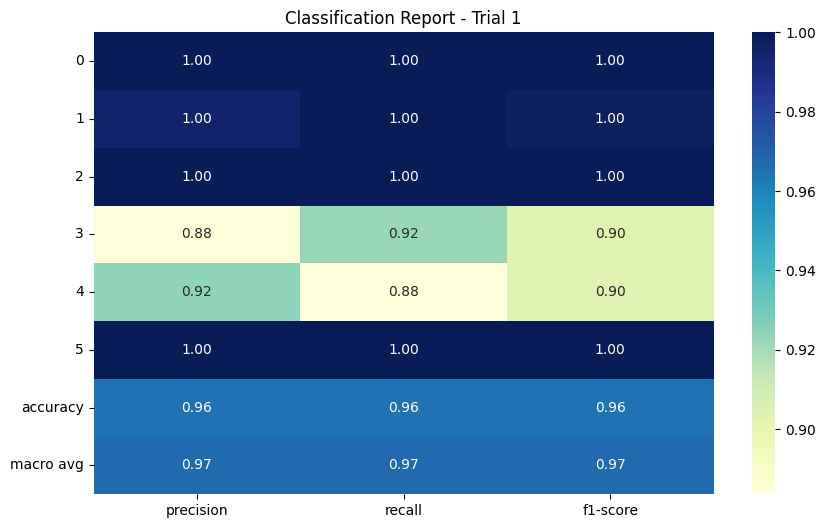

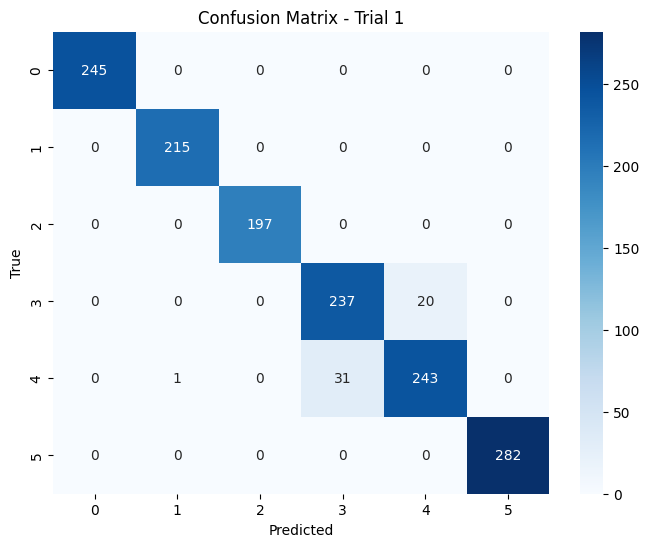


🔁 Trial 2/20
Hyperparameters: {'l2_reg': 0.008471801418819973, 'batch_size': 32, 'learning_rate': 0.00015751320499779724, 'num_conv_layers': 1, 'num_filters': 32, 'kernel_size': 3, 'lstm_units': 64, 'dense_units': 256, 'dropout_rate': 0.3806056187149941}
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.3953 - loss: 3.0091 - val_accuracy: 0.6723 - val_loss: 2.0986 - learning_rate: 1.5751e-04
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.6566 - loss: 2.0232 - val_accuracy: 0.7655 - val_loss: 1.6186 - learning_rate: 1.5751e-04
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.6932 - loss: 1.6551 - val_accuracy: 0.8131 - val_loss: 1.3694 - learning_rate: 1.5751e-04
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.7429 - loss: 1.4099 - val_accuracy: 0.8511 - val_loss: 1.1309 - learning_rate: 1.5751e-04
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.7926 - loss: 1.1901 - val_accuracy: 0.8770 -

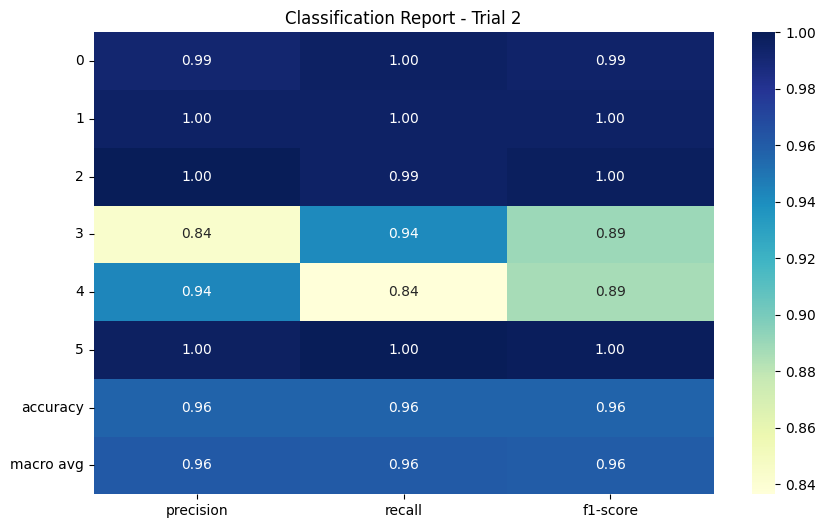

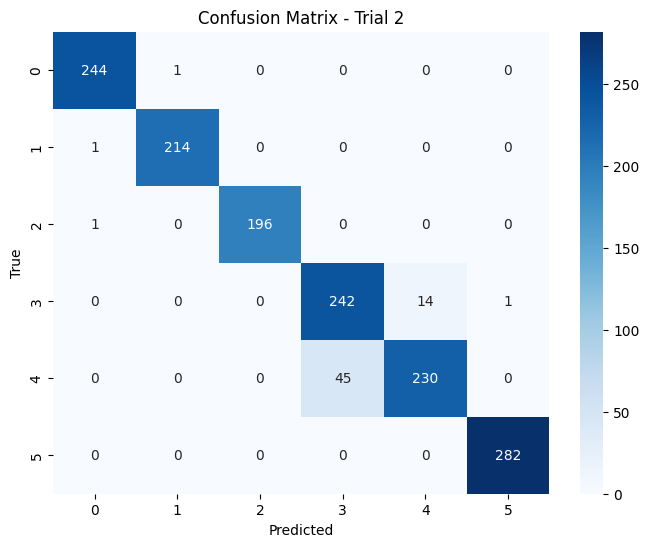


🔁 Trial 3/20
Hyperparameters: {'l2_reg': 4.2079886696066304e-05, 'batch_size': 128, 'learning_rate': 2.051110418843398e-05, 'num_conv_layers': 2, 'num_filters': 32, 'kernel_size': 3, 'lstm_units': 256, 'dense_units': 128, 'dropout_rate': 0.30207515495539755}
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.2958 - loss: 1.7765 - val_accuracy: 0.5173 - val_loss: 1.7064 - learning_rate: 2.0511e-05
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 753ms/step - accuracy: 0.4444 - loss: 1.6158 - val_accuracy: 0.5602 - val_loss: 1.5373 - learning_rate: 2.0511e-05
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 502ms/step - accuracy: 0.5080 - loss: 1.4356 - val_accuracy: 0.5948 - val_loss: 1.2961 - learning_rate: 2.0511e-05
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 495ms/step - accuracy: 0.5602 - loss: 1.2414 - val_accuracy: 0.6227 - val_loss: 1.0903 - learning_rate: 2.0511e-05
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.5871 - loss: 1.0800 - val_accuracy: 0.6533 - val_l

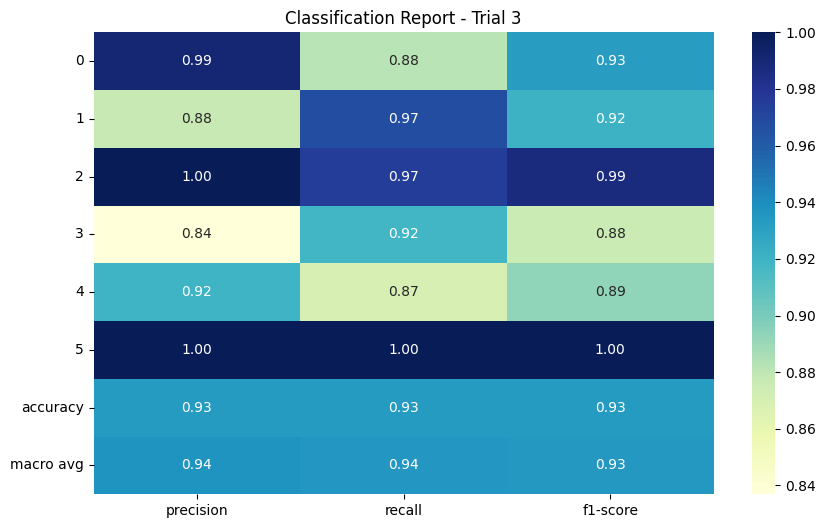

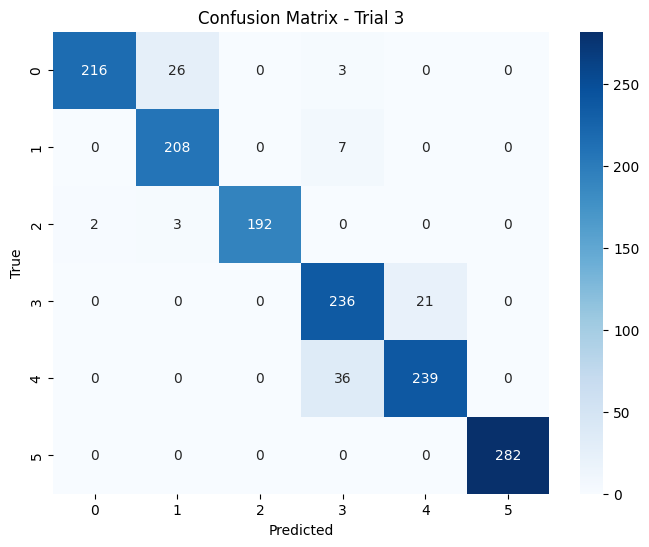


🔁 Trial 4/20
Hyperparameters: {'l2_reg': 1.7073967431528134e-05, 'batch_size': 128, 'learning_rate': 0.0005399484409787428, 'num_conv_layers': 2, 'num_filters': 32, 'kernel_size': 7, 'lstm_units': 128, 'dense_units': 256, 'dropout_rate': 0.23744784885596282}
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 612ms/step - accuracy: 0.5486 - loss: 1.3056 - val_accuracy: 0.5751 - val_loss: 1.6978 - learning_rate: 5.3995e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 545ms/step - accuracy: 0.8356 - loss: 0.4504 - val_accuracy: 0.7648 - val_loss: 1.0576 - learning_rate: 5.3995e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 530ms/step - accuracy: 0.9252 - loss: 0.2205 - val_accuracy: 0.9082 - val_loss: 0.3096 - learning_rate: 5.3995e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 516ms/step - accuracy: 0.9420 - loss: 0.1646 - val_accuracy: 0.9239 - val_loss: 0.2582 - learning_rate: 5.3995e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 533ms/step - accuracy: 0.9460 - loss: 0.1469 - val_accuracy: 0.9511 - 

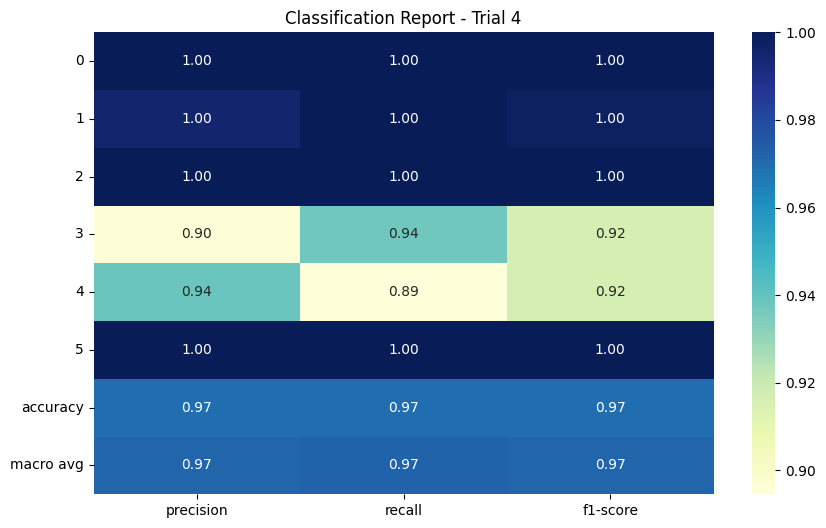

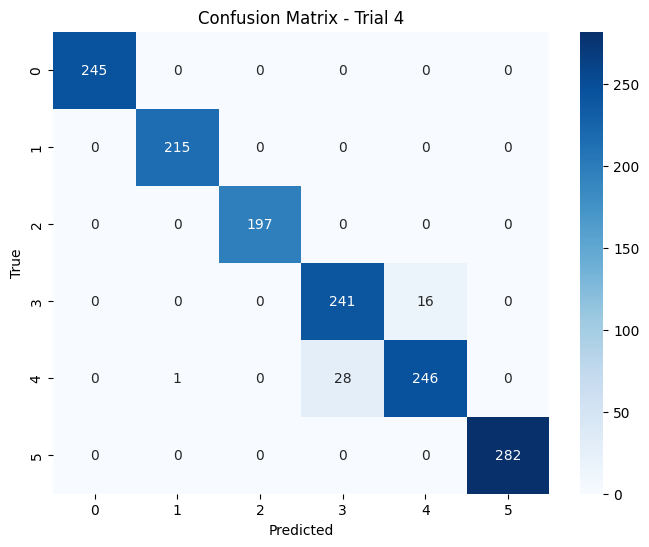


🔁 Trial 5/20
Hyperparameters: {'l2_reg': 0.0025378155082656628, 'batch_size': 128, 'learning_rate': 0.00026070247583707664, 'num_conv_layers': 1, 'num_filters': 128, 'kernel_size': 3, 'lstm_units': 64, 'dense_units': 256, 'dropout_rate': 0.26836948269546407}
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 334ms/step - accuracy: 0.4246 - loss: 2.3229 - val_accuracy: 0.5955 - val_loss: 2.0554 - learning_rate: 2.6070e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - accuracy: 0.7088 - loss: 1.6210 - val_accuracy: 0.6866 - val_loss: 1.6238 - learning_rate: 2.6070e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 305ms/step - accuracy: 0.7667 - loss: 1.3073 - val_accuracy: 0.8321 - val_loss: 1.2140 - learning_rate: 2.6070e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 316ms/step - accuracy: 0.8244 - loss: 1.1210 - val_accuracy: 0.9035 - val_loss: 0.9458 - learning_rate: 2.6070e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 290ms/step - accuracy: 0.8965 - loss: 0.9084 - val_accuracy: 0.9266 - 

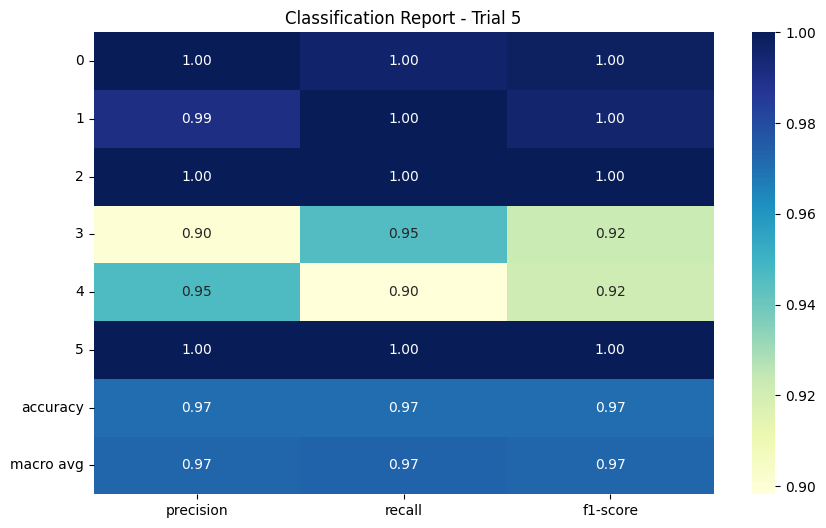

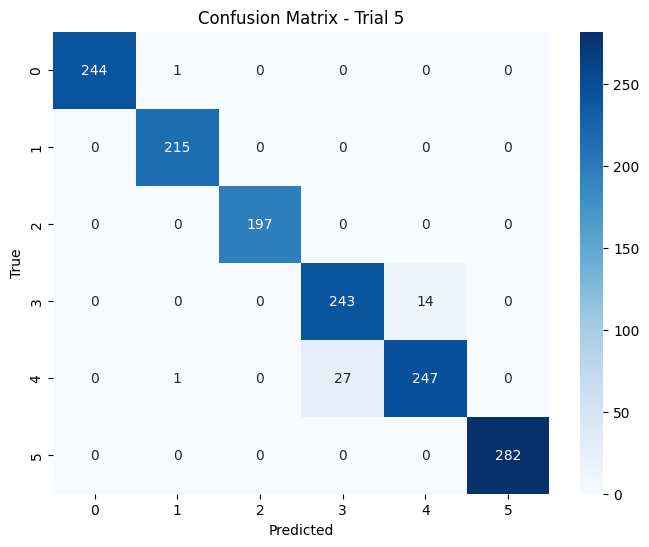


🔁 Trial 6/20
Hyperparameters: {'l2_reg': 1.2087541473056955e-05, 'batch_size': 128, 'learning_rate': 0.0008706020878304845, 'num_conv_layers': 2, 'num_filters': 32, 'kernel_size': 5, 'lstm_units': 128, 'dense_units': 64, 'dropout_rate': 0.40105255231330805}
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 487ms/step - accuracy: 0.4706 - loss: 1.3481 - val_accuracy: 0.4188 - val_loss: 1.9073 - learning_rate: 8.7060e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - accuracy: 0.7344 - loss: 0.6475 - val_accuracy: 0.7029 - val_loss: 1.2079 - learning_rate: 8.7060e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - accuracy: 0.8653 - loss: 0.3993 - val_accuracy: 0.7614 - val_loss: 0.6742 - learning_rate: 8.7060e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.9062 - loss: 0.2809 - val_accuracy: 0.9048 - val_loss: 0.2925 - learning_rate: 8.7060e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 441ms/step - accuracy: 0.9341 - loss: 0.1867 - val_accuracy: 0.9551 - v

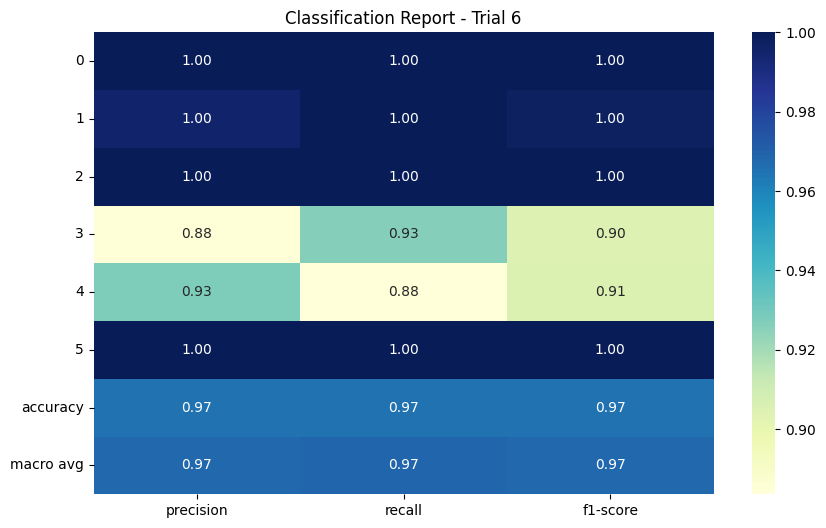

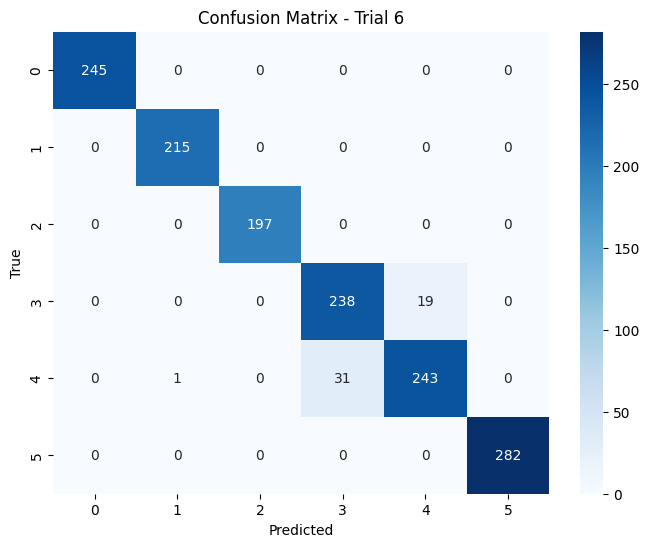


🔁 Trial 7/20
Hyperparameters: {'l2_reg': 0.02136832907235874, 'batch_size': 64, 'learning_rate': 2.6587543983272722e-05, 'num_conv_layers': 2, 'num_filters': 64, 'kernel_size': 7, 'lstm_units': 256, 'dense_units': 256, 'dropout_rate': 0.2658845521910807}
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 282ms/step - accuracy: 0.3033 - loss: 11.4372 - val_accuracy: 0.5337 - val_loss: 10.8671 - learning_rate: 2.6588e-05
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 276ms/step - accuracy: 0.6050 - loss: 10.4800 - val_accuracy: 0.6336 - val_loss: 9.8615 - learning_rate: 2.6588e-05
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 315ms/step - accuracy: 0.6628 - loss: 9.6486 - val_accuracy: 0.7104 - val_loss: 9.0783 - learning_rate: 2.6588e-05
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 271ms/step - accuracy: 0.6845 - loss: 8.9924 - val_accuracy: 0.7634 - val_loss: 8.4736 - learning_rate: 2.6588e-05
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 247ms/step - accuracy: 0.7148 - loss: 8.4294 - val_accuracy: 0.8253 - v

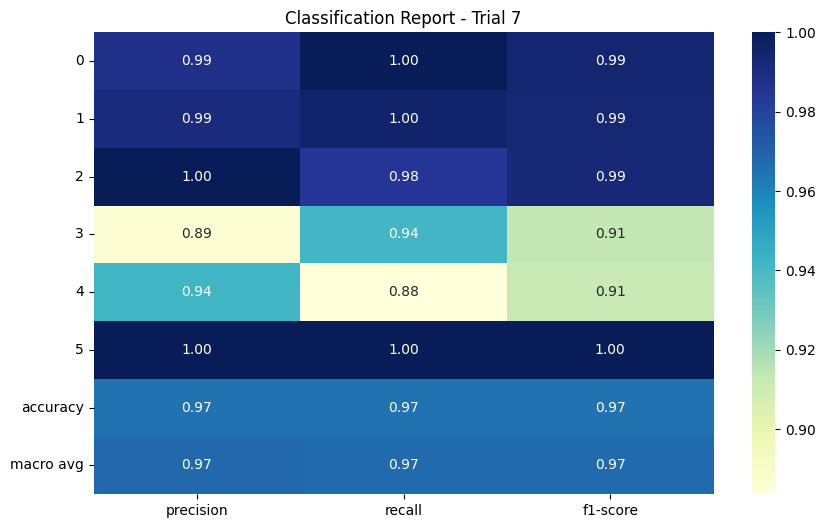

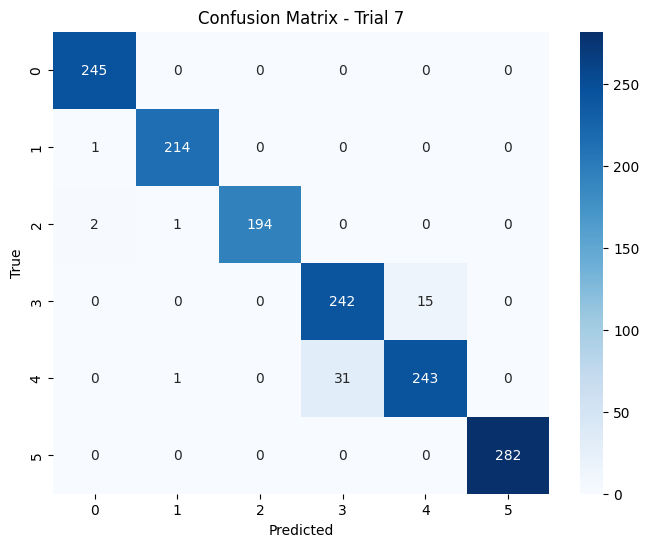


🔁 Trial 8/20
Hyperparameters: {'l2_reg': 5.337032762603955e-05, 'batch_size': 64, 'learning_rate': 2.3270677083837774e-05, 'num_conv_layers': 1, 'num_filters': 32, 'kernel_size': 7, 'lstm_units': 256, 'dense_units': 128, 'dropout_rate': 0.2637879632162422}
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 317ms/step - accuracy: 0.3565 - loss: 1.7023 - val_accuracy: 0.6064 - val_loss: 1.5659 - learning_rate: 2.3271e-05
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 434ms/step - accuracy: 0.5707 - loss: 1.3646 - val_accuracy: 0.6893 - val_loss: 1.1304 - learning_rate: 2.3271e-05
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 526ms/step - accuracy: 0.6497 - loss: 1.0482 - val_accuracy: 0.7322 - val_loss: 0.7968 - learning_rate: 2.3271e-05
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 595ms/step - accuracy: 0.7118 - loss: 0.8469 - val_accuracy: 0.7743 - val_loss: 0.6597 - learning_rate: 2.3271e-05
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 611ms/step - accuracy: 0.7173 - loss: 0.7255 - val_accuracy: 0.8273 - va

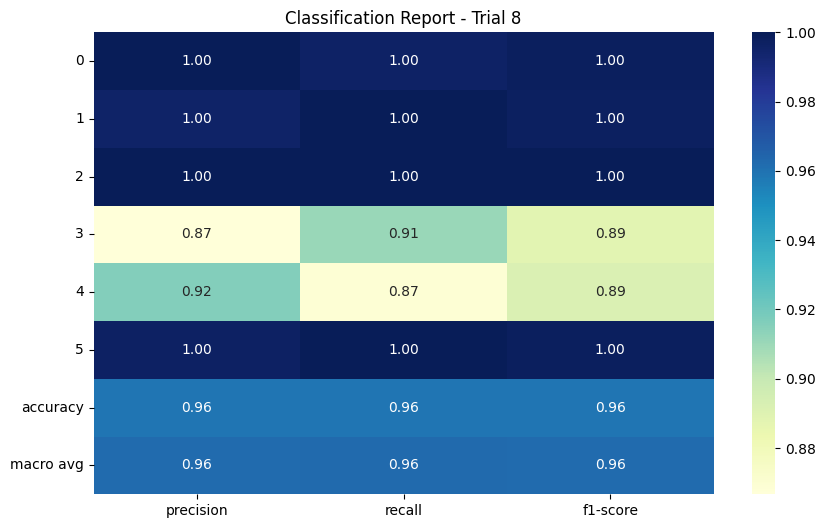

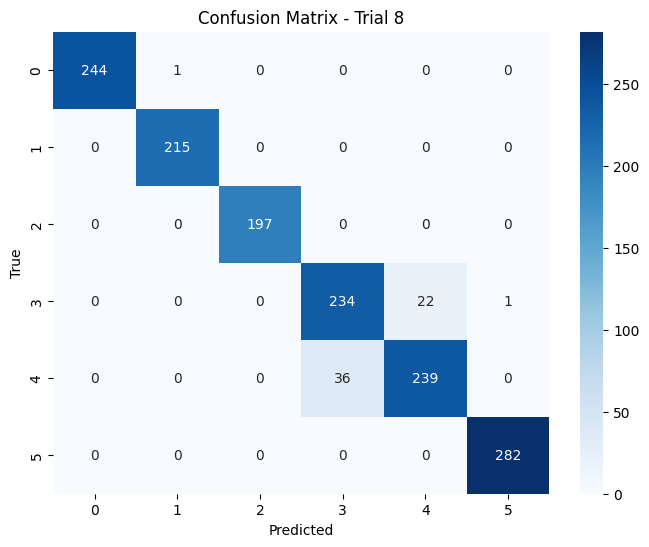


🔁 Trial 9/20
Hyperparameters: {'l2_reg': 0.00016480446427978967, 'batch_size': 32, 'learning_rate': 0.00011207606211860571, 'num_conv_layers': 3, 'num_filters': 128, 'kernel_size': 7, 'lstm_units': 128, 'dense_units': 256, 'dropout_rate': 0.37537579706706214}
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.5083 - loss: 1.4512 - val_accuracy: 0.7036 - val_loss: 0.7580 - learning_rate: 1.1208e-04
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.7555 - loss: 0.7265 - val_accuracy: 0.9123 - val_loss: 0.3815 - learning_rate: 1.1208e-04
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.8863 - loss: 0.4262 - val_accuracy: 0.9579 - val_loss: 0.2461 - learning_rate: 1.1208e-04
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.9313 - loss: 0.2923 - val_accuracy: 0.9558 - val_loss: 0.2308 - learning_rate: 1.1208e-04
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.9304 - loss: 0.2924 - val_accuracy: 0.9

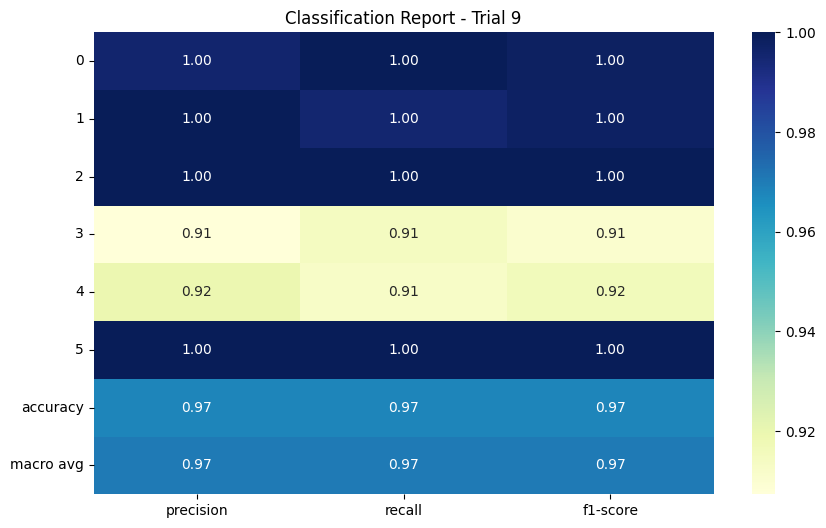

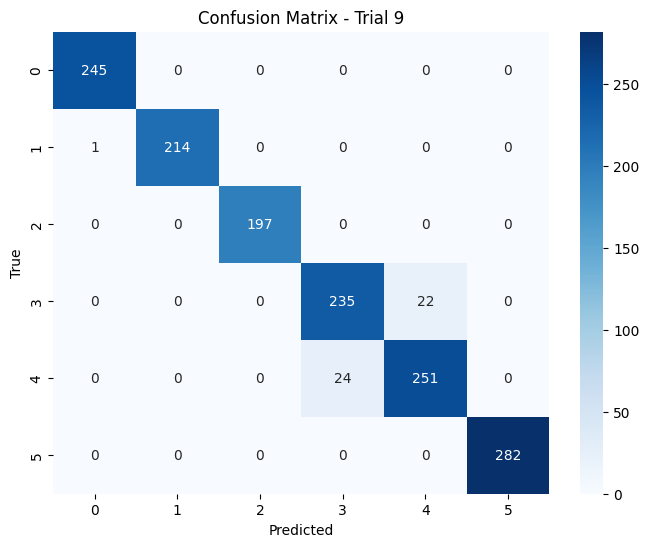


🔁 Trial 10/20
Hyperparameters: {'l2_reg': 0.0005342937261279772, 'batch_size': 32, 'learning_rate': 3.823475224675187e-05, 'num_conv_layers': 3, 'num_filters': 32, 'kernel_size': 7, 'lstm_units': 128, 'dense_units': 256, 'dropout_rate': 0.21905831184558716}
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.3494 - loss: 1.8469 - val_accuracy: 0.6261 - val_loss: 1.3763 - learning_rate: 3.8235e-05
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.6173 - loss: 1.2384 - val_accuracy: 0.7322 - val_loss: 0.8516 - learning_rate: 3.8235e-05
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.6951 - loss: 0.8998 - val_accuracy: 0.8035 - val_loss: 0.7341 - learning_rate: 3.8235e-05
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.7160 - loss: 0.8130 - val_accuracy: 0.8287 - val_loss: 0.6425 - learning_rate: 3.8235e-05
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.7784 - loss: 0.7177 - val_accuracy: 0.836

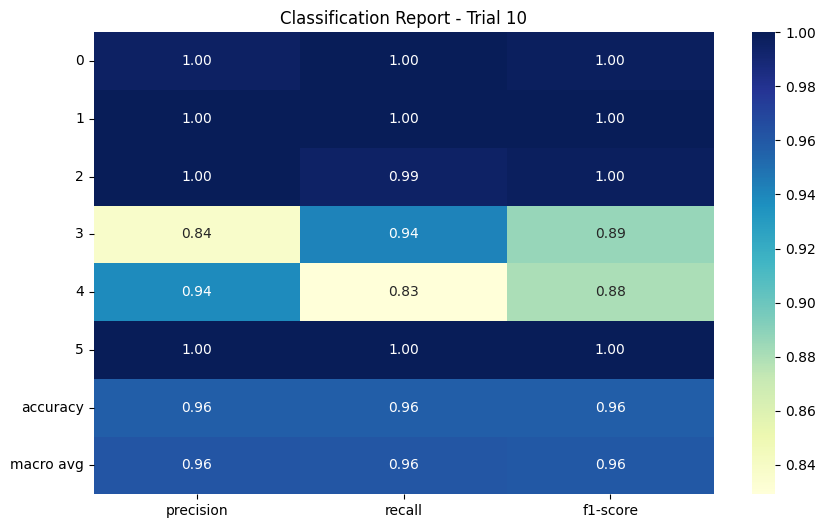

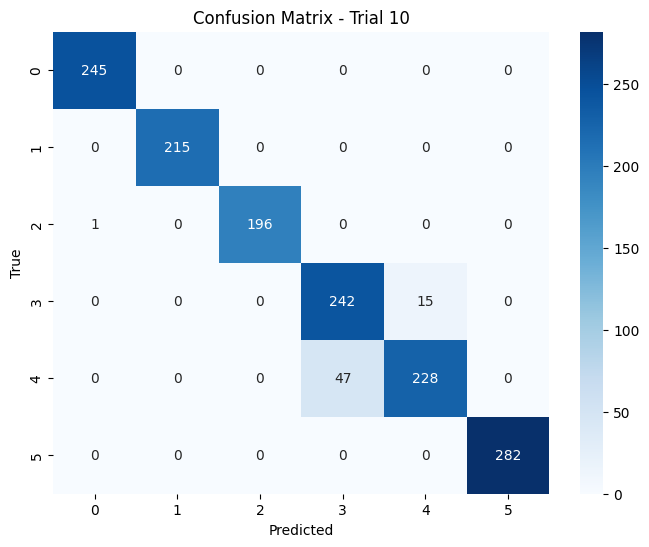


🔁 Trial 11/20
Hyperparameters: {'l2_reg': 0.0028016351587162583, 'batch_size': 128, 'learning_rate': 1.901024531987036e-05, 'num_conv_layers': 2, 'num_filters': 128, 'kernel_size': 5, 'lstm_units': 64, 'dense_units': 128, 'dropout_rate': 0.33042957520073146}
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.1871 - loss: 2.9588 - val_accuracy: 0.2508 - val_loss: 2.8715 - learning_rate: 1.9010e-05
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step - accuracy: 0.3388 - loss: 2.8215 - val_accuracy: 0.2583 - val_loss: 2.7870 - learning_rate: 1.9010e-05
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 276ms/step - accuracy: 0.4688 - loss: 2.6893 - val_accuracy: 0.5472 - val_loss: 2.6805 - learning_rate: 1.9010e-05
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 283ms/step - accuracy: 0.5341 - loss: 2.5874 - val_accuracy: 0.5935 - val_loss: 2.5575 - learning_rate: 1.9010e-05
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 282ms/step - accuracy: 0.5677 - loss: 2.5131 - val_accuracy: 0.6329 - 

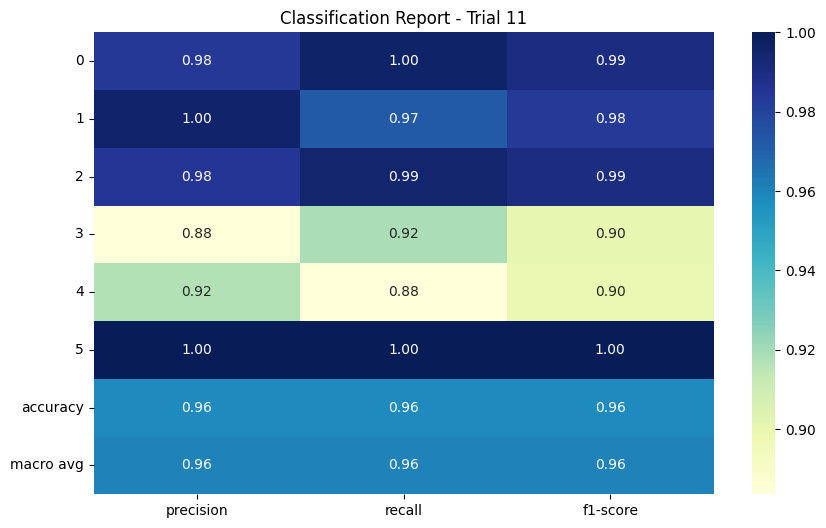

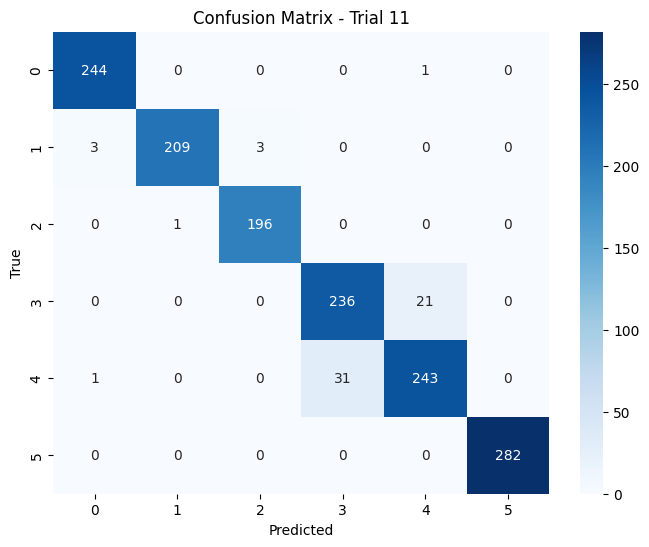


🔁 Trial 12/20
Hyperparameters: {'l2_reg': 0.00014742753159914664, 'batch_size': 32, 'learning_rate': 5.404103854647327e-05, 'num_conv_layers': 3, 'num_filters': 64, 'kernel_size': 7, 'lstm_units': 256, 'dense_units': 256, 'dropout_rate': 0.25967333052941993}
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 42s 217ms/step - accuracy: 0.5210 - loss: 1.4597 - val_accuracy: 0.6812 - val_loss: 0.7536 - learning_rate: 5.4041e-05
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - accuracy: 0.7445 - loss: 0.7029 - val_accuracy: 0.9109 - val_loss: 0.3666 - learning_rate: 5.4041e-05
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 216ms/step - accuracy: 0.8824 - loss: 0.3864 - val_accuracy: 0.9511 - val_loss: 0.2238 - learning_rate: 5.4041e-05
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 217ms/step - accuracy: 0.9317 - loss: 0.2649 - val_accuracy: 0.9606 - val_loss: 0.1964 - learning_rate: 5.4041e-05
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 218ms/step - accuracy: 0.9392 - loss: 0.2472 - val_accuracy:

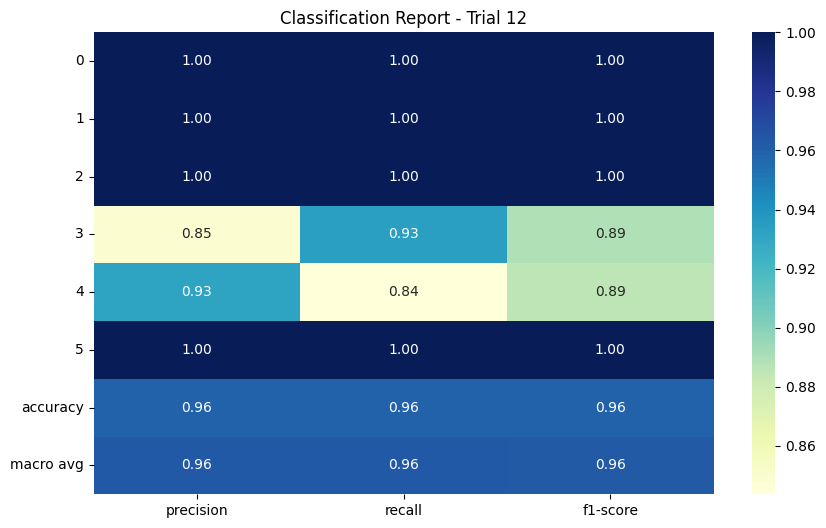

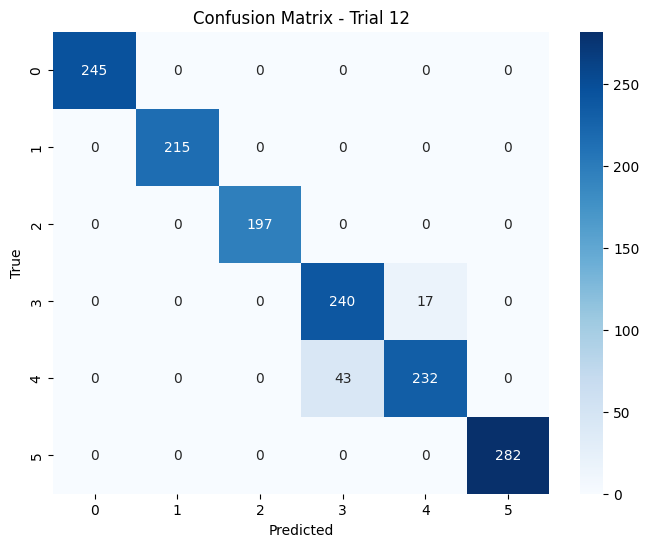


🔁 Trial 13/20
Hyperparameters: {'l2_reg': 0.0006672367170464204, 'batch_size': 32, 'learning_rate': 0.00037183641805732065, 'num_conv_layers': 2, 'num_filters': 64, 'kernel_size': 3, 'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.46340287976121214}
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.4346 - loss: 1.6283 - val_accuracy: 0.7301 - val_loss: 0.8481 - learning_rate: 3.7184e-04
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.6576 - loss: 0.9856 - val_accuracy: 0.7947 - val_loss: 0.6846 - learning_rate: 3.7184e-04
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.7260 - loss: 0.8192 - val_accuracy: 0.8600 - val_loss: 0.5583 - learning_rate: 3.7184e-04
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.7922 - loss: 0.6812 - val_accuracy: 0.8919 - val_loss: 0.4509 - learning_rate: 3.7184e-04
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.8685 - loss: 0.5564 - val_accuracy: 0.9225

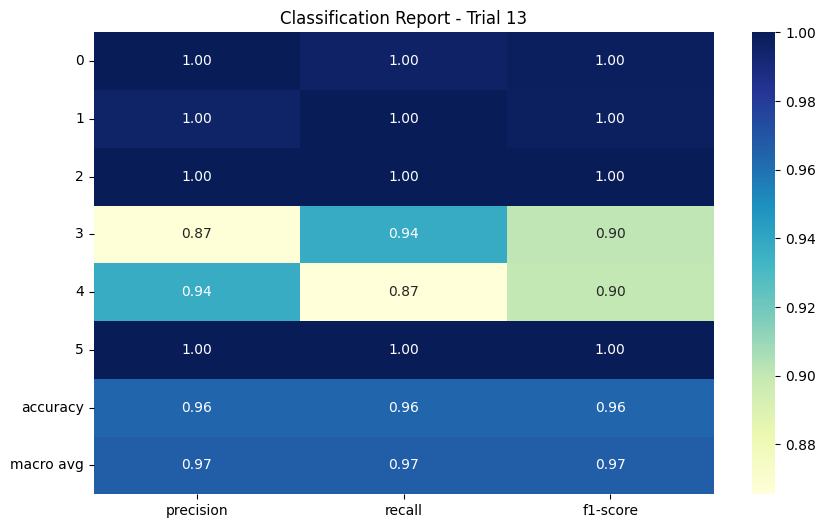

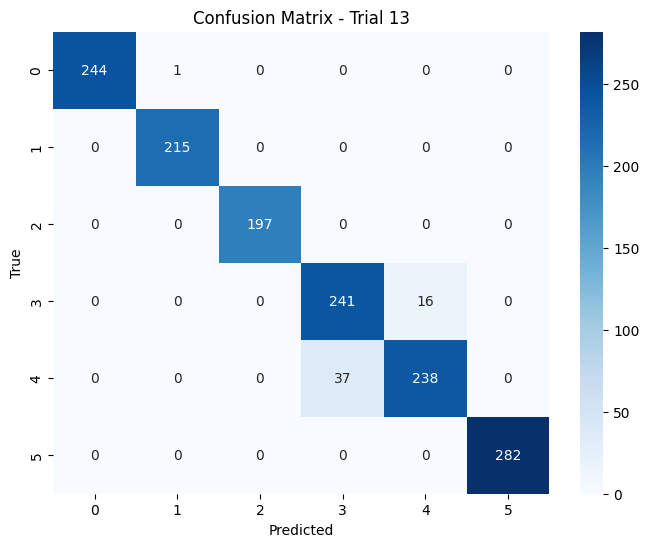


🔁 Trial 14/20
Hyperparameters: {'l2_reg': 6.29064429458614e-05, 'batch_size': 128, 'learning_rate': 0.00010677482709481354, 'num_conv_layers': 2, 'num_filters': 128, 'kernel_size': 3, 'lstm_units': 128, 'dense_units': 256, 'dropout_rate': 0.46172991232557725}
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 361ms/step - accuracy: 0.3123 - loss: 1.7401 - val_accuracy: 0.5921 - val_loss: 1.4737 - learning_rate: 1.0677e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 0.5721 - loss: 1.2638 - val_accuracy: 0.6377 - val_loss: 1.0168 - learning_rate: 1.0677e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.6567 - loss: 0.9572 - val_accuracy: 0.6941 - val_loss: 0.7417 - learning_rate: 1.0677e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step - accuracy: 0.6790 - loss: 0.8046 - val_accuracy: 0.7063 - val_loss: 0.6272 - learning_rate: 1.0677e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 350ms/step - accuracy: 0.6972 - loss: 0.7311 - val_accuracy: 0.7437 -

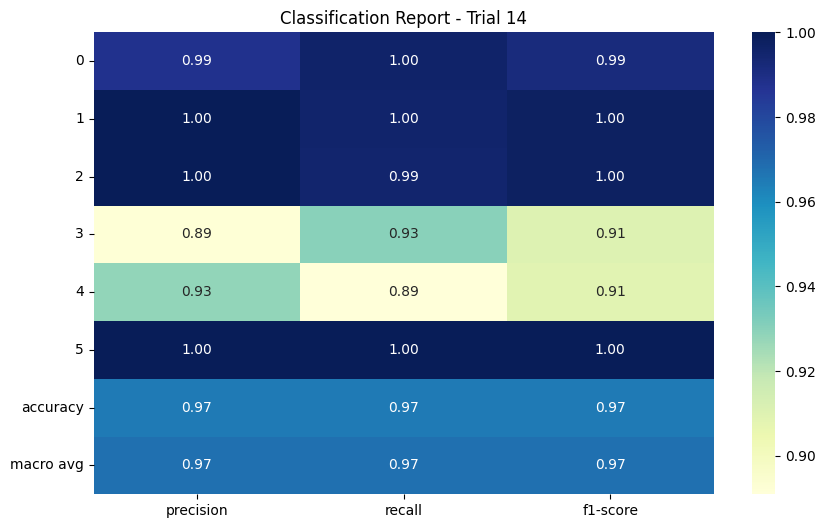

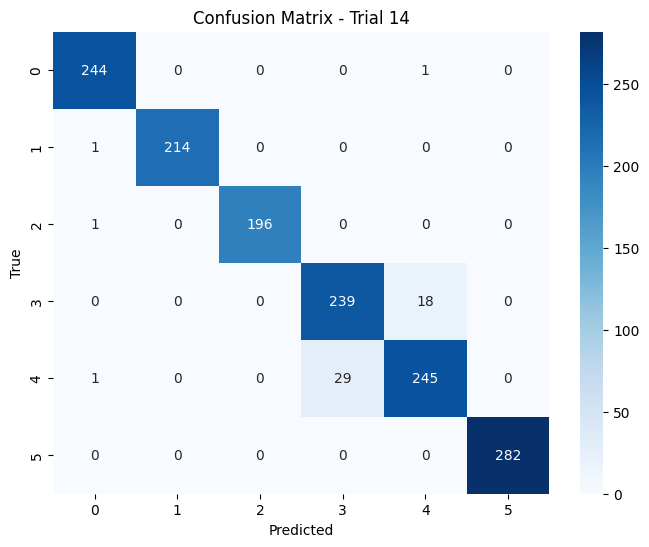


🔁 Trial 15/20
Hyperparameters: {'l2_reg': 0.00234238498471129, 'batch_size': 128, 'learning_rate': 1.2385137298860936e-05, 'num_conv_layers': 3, 'num_filters': 64, 'kernel_size': 5, 'lstm_units': 256, 'dense_units': 128, 'dropout_rate': 0.23630125876047972}
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 29s 568ms/step - accuracy: 0.1753 - loss: 2.8137 - val_accuracy: 0.4283 - val_loss: 2.7852 - learning_rate: 1.2385e-05
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 27s 591ms/step - accuracy: 0.4059 - loss: 2.6981 - val_accuracy: 0.3936 - val_loss: 2.7183 - learning_rate: 1.2385e-05
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 28s 612ms/step - accuracy: 0.5313 - loss: 2.5767 - val_accuracy: 0.3895 - val_loss: 2.6023 - learning_rate: 1.2385e-05
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 28s 607ms/step - accuracy: 0.5827 - loss: 2.4442 - val_accuracy: 0.4256 - val_loss: 2.4343 - learning_rate: 1.2385e-05
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 28s 615ms/step - accuracy: 0.6110 - loss: 2.3076 - val_accuracy: 0.4983 - v

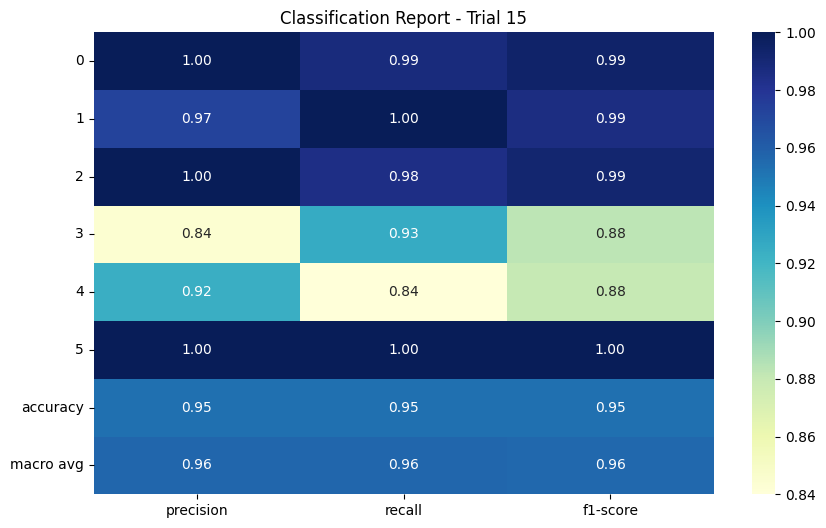

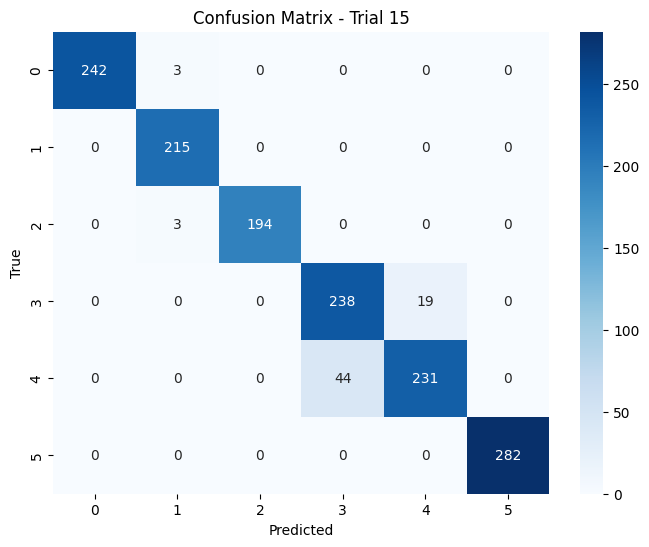


🔁 Trial 16/20
Hyperparameters: {'l2_reg': 0.002692646910086177, 'batch_size': 32, 'learning_rate': 2.1930485556643675e-05, 'num_conv_layers': 1, 'num_filters': 32, 'kernel_size': 3, 'lstm_units': 128, 'dense_units': 64, 'dropout_rate': 0.3542468359425768}
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.2633 - loss: 2.1774 - val_accuracy: 0.5527 - val_loss: 1.9477 - learning_rate: 2.1930e-05
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.5206 - loss: 1.9187 - val_accuracy: 0.5921 - val_loss: 1.6604 - learning_rate: 2.1930e-05
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.5711 - loss: 1.7217 - val_accuracy: 0.6377 - val_loss: 1.4543 - learning_rate: 2.1930e-05
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.6021 - loss: 1.5602 - val_accuracy: 0.6778 - val_loss: 1.3079 - learning_rate: 2.1930e-05
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.6405 - loss: 1.4363 - val_accuracy: 0.7084 

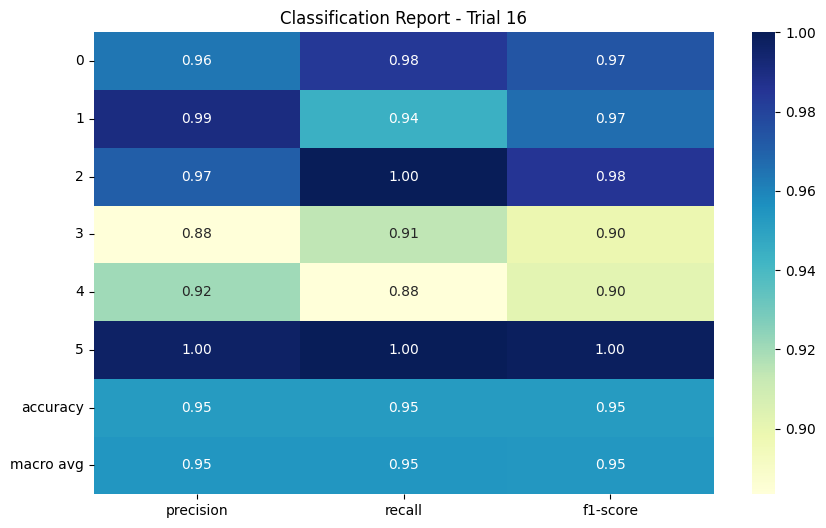

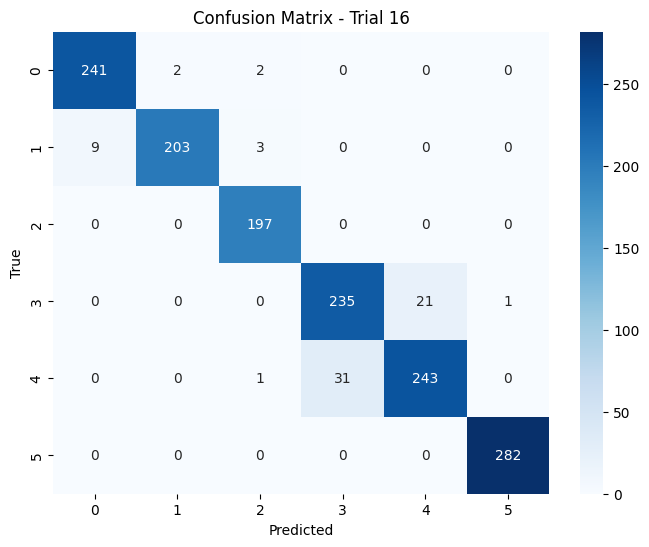


🔁 Trial 17/20
Hyperparameters: {'l2_reg': 1.8205657658407255e-05, 'batch_size': 128, 'learning_rate': 0.0007902619549708221, 'num_conv_layers': 2, 'num_filters': 32, 'kernel_size': 5, 'lstm_units': 128, 'dense_units': 64, 'dropout_rate': 0.22829773894756467}
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.5674 - loss: 1.2168 - val_accuracy: 0.5534 - val_loss: 2.1235 - learning_rate: 7.9026e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - accuracy: 0.8259 - loss: 0.4929 - val_accuracy: 0.8165 - val_loss: 0.5655 - learning_rate: 7.9026e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - accuracy: 0.9186 - loss: 0.2409 - val_accuracy: 0.9130 - val_loss: 0.2951 - learning_rate: 7.9026e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.9292 - loss: 0.1858 - val_accuracy: 0.9402 - val_loss: 0.1859 - learning_rate: 7.9026e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - accuracy: 0.9489 - loss: 0.1371 - val_accuracy: 0.9375 - 

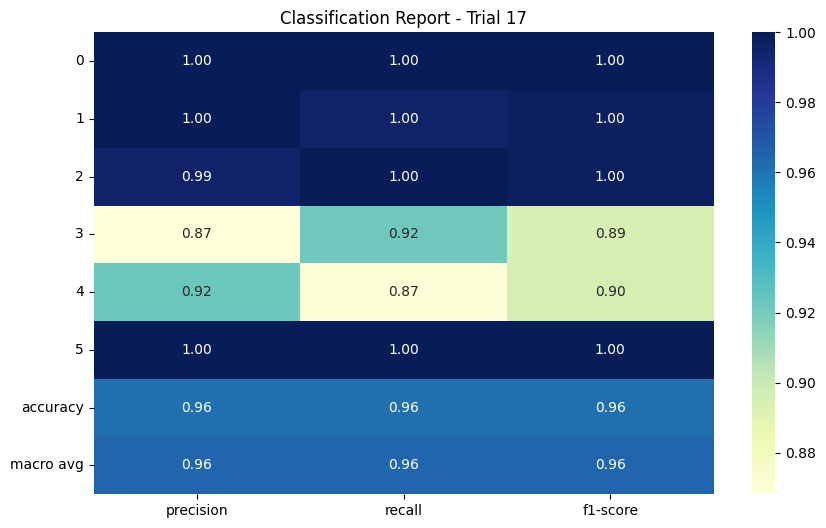

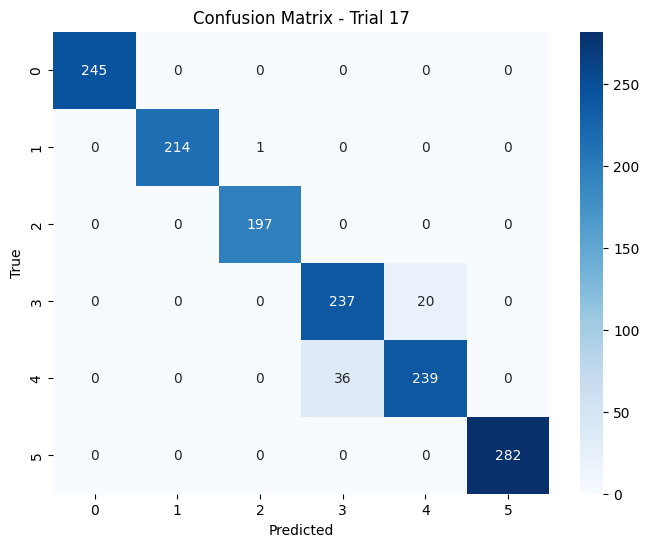


🔁 Trial 18/20
Hyperparameters: {'l2_reg': 0.07286653737491036, 'batch_size': 128, 'learning_rate': 0.0004138040112561016, 'num_conv_layers': 1, 'num_filters': 32, 'kernel_size': 5, 'lstm_units': 256, 'dense_units': 128, 'dropout_rate': 0.4401777532585096}
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 514ms/step - accuracy: 0.4593 - loss: 17.5731 - val_accuracy: 0.3481 - val_loss: 12.4320 - learning_rate: 4.1380e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 519ms/step - accuracy: 0.6734 - loss: 10.4604 - val_accuracy: 0.4609 - val_loss: 7.7320 - learning_rate: 4.1380e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 523ms/step - accuracy: 0.7511 - loss: 6.5407 - val_accuracy: 0.7186 - val_loss: 4.7647 - learning_rate: 4.1380e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 527ms/step - accuracy: 0.8393 - loss: 4.1194 - val_accuracy: 0.7396 - val_loss: 3.2436 - learning_rate: 4.1380e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 540ms/step - accuracy: 0.8505 - loss: 2.8036 - val_accuracy: 0.8525 - 

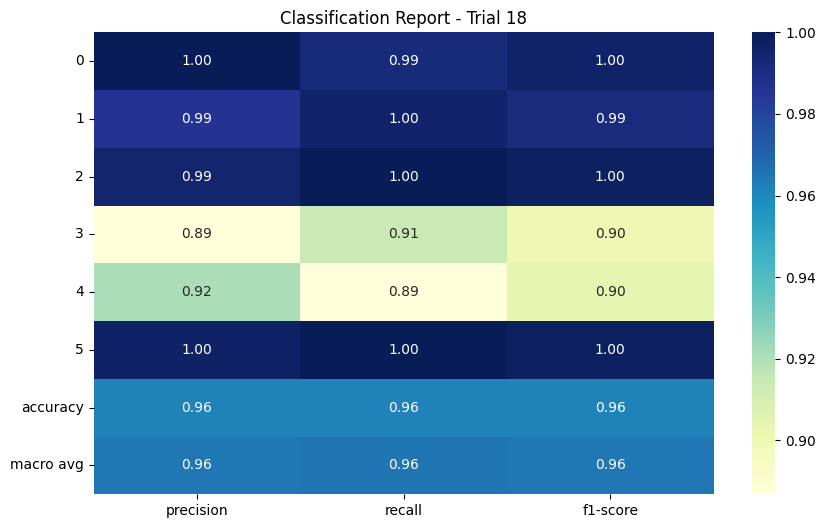

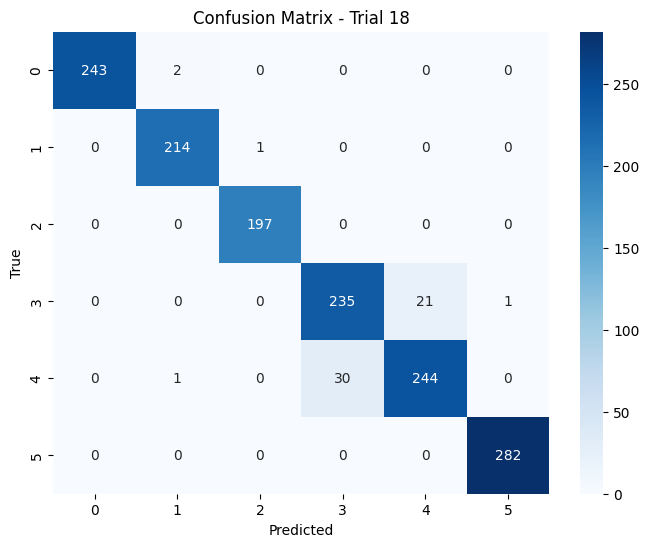


🔁 Trial 19/20
Hyperparameters: {'l2_reg': 0.00016536937182824417, 'batch_size': 64, 'learning_rate': 1.5679933916723022e-05, 'num_conv_layers': 2, 'num_filters': 32, 'kernel_size': 3, 'lstm_units': 128, 'dense_units': 256, 'dropout_rate': 0.22937261846048013}
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 531ms/step - accuracy: 0.2356 - loss: 1.7850 - val_accuracy: 0.5534 - val_loss: 1.7249 - learning_rate: 1.5680e-05
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 535ms/step - accuracy: 0.5283 - loss: 1.6525 - val_accuracy: 0.6281 - val_loss: 1.5640 - learning_rate: 1.5680e-05
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 633ms/step - accuracy: 0.6166 - loss: 1.5103 - val_accuracy: 0.6370 - val_loss: 1.3615 - learning_rate: 1.5680e-05
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 625ms/step - accuracy: 0.6342 - loss: 1.3621 - val_accuracy: 0.6662 - val_loss: 1.1684 - learning_rate: 1.5680e-05
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 529ms/step - accuracy: 0.6556 - loss: 1.2115 - val_accuracy: 0.6968 -

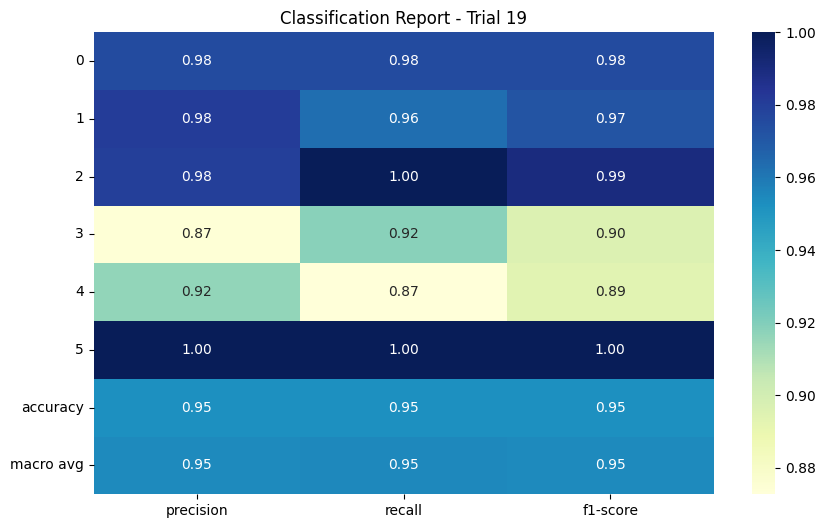

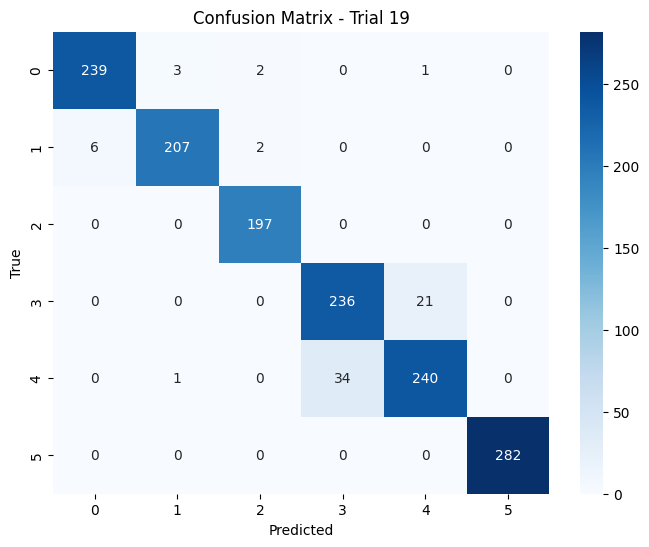


🔁 Trial 20/20
Hyperparameters: {'l2_reg': 0.005456725485601473, 'batch_size': 64, 'learning_rate': 7.5911048052827e-05, 'num_conv_layers': 2, 'num_filters': 32, 'kernel_size': 5, 'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.31369193569307485}
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.3510 - loss: 2.6004 - val_accuracy: 0.4956 - val_loss: 2.4223 - learning_rate: 7.5911e-05
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.5093 - loss: 2.2813 - val_accuracy: 0.5656 - val_loss: 2.0196 - learning_rate: 7.5911e-05
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.5634 - loss: 2.0109 - val_accuracy: 0.6914 - val_loss: 1.7707 - learning_rate: 7.5911e-05
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.6028 - loss: 1.8244 - val_accuracy: 0.7056 - val_loss: 1.5909 - learning_rate: 7.5911e-05
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.6632 - loss: 1.6692 - val_accuracy: 0.7308 - val_loss: 1.

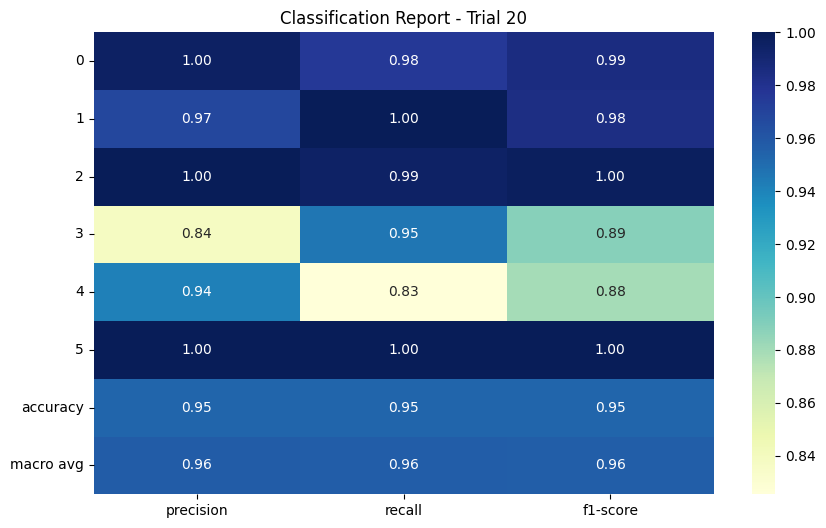

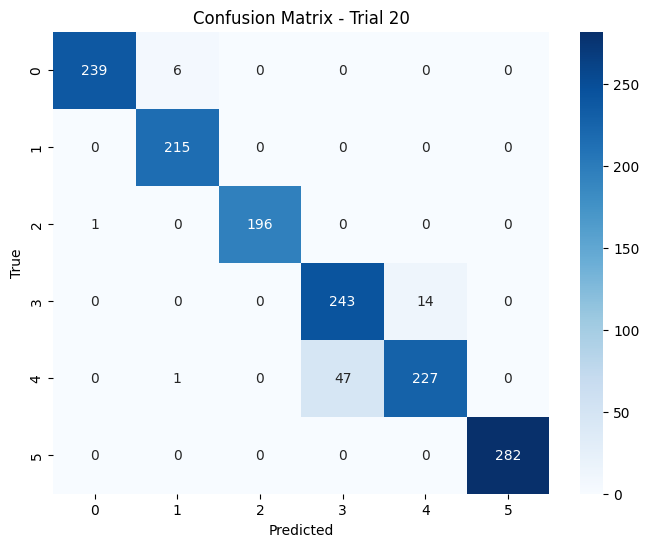


🏁 Top 5 Configurations by Macro F1-Score:
1. F1=0.9729, Params={'l2_reg': 0.0025378155082656628, 'batch_size': 128, 'learning_rate': 0.00026070247583707664, 'num_conv_layers': 1, 'num_filters': 128, 'kernel_size': 3, 'lstm_units': 64, 'dense_units': 256, 'dropout_rate': 0.26836948269546407}
2. F1=0.9717, Params={'l2_reg': 1.7073967431528134e-05, 'batch_size': 128, 'learning_rate': 0.0005399484409787428, 'num_conv_layers': 2, 'num_filters': 32, 'kernel_size': 7, 'lstm_units': 128, 'dense_units': 256, 'dropout_rate': 0.23744784885596282}
3. F1=0.9704, Params={'l2_reg': 0.00016480446427978967, 'batch_size': 32, 'learning_rate': 0.00011207606211860571, 'num_conv_layers': 3, 'num_filters': 128, 'kernel_size': 7, 'lstm_units': 128, 'dense_units': 256, 'dropout_rate': 0.37537579706706214}
4. F1=0.9679, Params={'l2_reg': 1.2087541473056955e-05, 'batch_size': 128, 'learning_rate': 0.0008706020878304845, 'num_conv_layers': 2, 'num_filters': 32, 'kernel_size': 5, 'lstm_units': 128, 'dense_units'

In [15]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Fix seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# --- Search space ---
search_space = {
    'l2_reg': lambda: 10**np.random.uniform(-5, -1),
    'batch_size': lambda: random.choice([32, 64, 128]),
    'learning_rate': lambda: 10**np.random.uniform(-5, -3),
    'num_conv_layers': lambda: random.choice([1, 2, 3]),
    'num_filters': lambda: random.choice([32, 64, 128]),
    'kernel_size': lambda: random.choice([3, 5, 7]),
    'lstm_units': lambda: random.choice([64, 128, 256]),
    'dense_units': lambda: random.choice([64, 128, 256]),
    'dropout_rate': lambda: random.uniform(0.2, 0.5)
}

# --- Model Builder ---
def build_model(input_shape, num_classes, hp):
    inputs = Input(shape=input_shape)
    x = inputs

    for _ in range(hp['num_conv_layers']):
        x = Conv1D(hp['num_filters'], kernel_size=hp['kernel_size'], padding='same',
                   activation='relu', kernel_regularizer=l2(hp['l2_reg']))(x)
        x = BatchNormalization()(x)
        x = Dropout(hp['dropout_rate'])(x)

    x = LSTM(hp['lstm_units'], return_sequences=False, kernel_regularizer=l2(hp['l2_reg']))(x)
    x = Dropout(hp['dropout_rate'])(x)

    x = Dense(hp['dense_units'], activation='relu', kernel_regularizer=l2(hp['l2_reg']))(x)
    x = Dropout(hp['dropout_rate'])(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    optimizer = Adam(learning_rate=hp['learning_rate'])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Train/Validation Split ---
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# --- Class Weights ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights))

# --- Random Search ---
n_trials = 20
results = []

for trial in range(1, n_trials + 1):
    print(f"\n🔁 Trial {trial}/{n_trials}")
    
    # Sample hyperparameters
    hp = {k: v() for k, v in search_space.items()}
    print(f"Hyperparameters: {hp}")
    
    model = build_model(input_shape=(ntimesteps, nfeatures), num_classes=len(np.unique(y_encoded)), hp=hp)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=hp['batch_size'],
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # --- Evaluation ---
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    report = classification_report(y_val, y_pred_classes, output_dict=True)
    report_text = classification_report(y_val, y_pred_classes)
    macro_f1 = report['macro avg']['f1-score']
    
    print(f"\n📋 Classification Report:\n{report_text}")
    print(f"📊 Macro F1 Score: {macro_f1:.4f}")
    results.append((hp, macro_f1))

    # --- Plot Classification Report Heatmap ---
    plt.figure(figsize=(10, 6))
    df_report = pd.DataFrame(report).transpose()
    sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f'Classification Report - Trial {trial}')
    plt.show()

    # --- Plot Confusion Matrix ---
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_encoded), yticklabels=np.unique(y_encoded))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Trial {trial}")
    plt.show()

# --- Sort and Report Top Results ---
results.sort(key=lambda x: x[1], reverse=True)

print("\n🏁 Top 5 Configurations by Macro F1-Score:")
for i, (hp, f1) in enumerate(results[:5], 1):
    print(f"{i}. F1={f1:.4f}, Params={hp}")

best_hp, best_f1 = results[0]
print(f"\n✅ Best Hyperparameters:\n{best_hp}\nMacro F1: {best_f1:.4f}")


In [16]:
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 128, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 128, 32)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 128, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 128, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 128, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,492 (427.71 KB)

 Trainable params: 36,454 (142.40 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 72,910 (284.81 KB)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 255ms/step - accuracy: 0.3874 - loss: 2.3241 - val_accuracy: 0.6567 - val_loss: 2.0518 - learning_rate: 2.6070e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - accuracy: 0.6985 - loss: 1.6346 - val_accuracy: 0.6982 - val_loss: 1.6677 - learning_rate: 2.6070e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 270ms/step - accuracy: 0.7777 - loss: 1.3059 - val_accuracy: 0.8375 - val_loss: 1.2098 - learning_rate: 2.6070e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.8358 - loss: 1.0978 - val_accuracy: 0.8858 - val_loss: 0.9561 - learning_rate: 2.6070e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step - accuracy: 0.8935 - loss: 0.9175 - val_accuracy: 0.9266 - val_loss: 0.7935 - learning_rate: 2.6070e-04
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.9308 - loss: 0.7608 - val_accuracy: 0.9409 - val_loss: 0.7183 - learning_rate: 2.6070e-04
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - acc

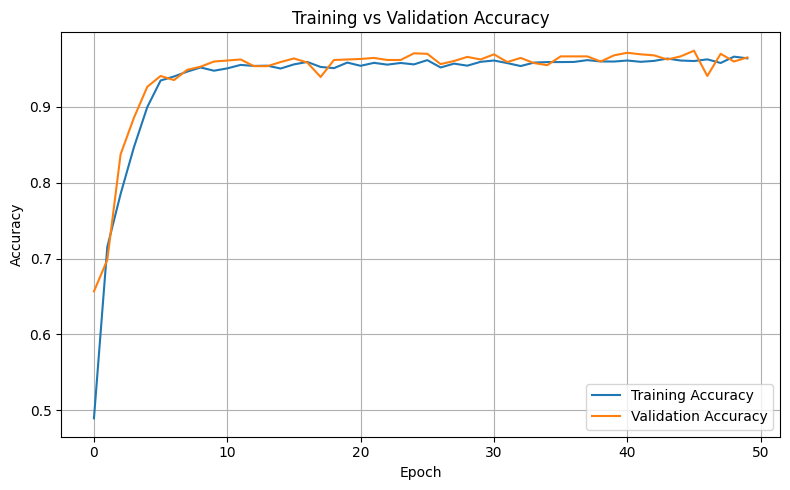

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       245
           1       1.00      1.00      1.00       215
           2       0.99      1.00      1.00       197
           3       0.93      0.92      0.93       257
           4       0.93      0.94      0.94       275
           5       1.00      1.00      1.00       282

    accuracy                           0.97      1471
   macro avg       0.98      0.98      0.98      1471
weighted avg       0.97      0.97      0.97      1471



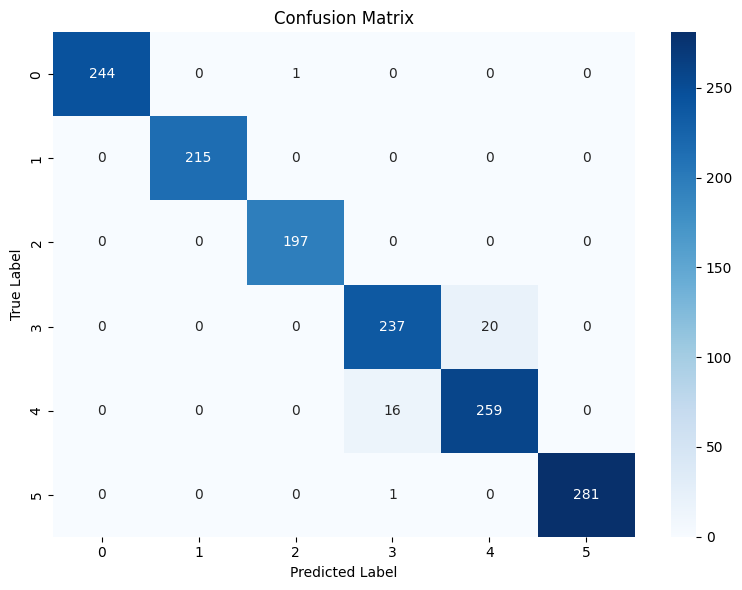

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 128, 11)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 128, 128)       │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,852 (847.08 KB)

 Trainable params: 72,198 (282.02 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 144,398 (564.06 KB)

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define best hyperparameters
best_hp = {
    'l2_reg': 0.0025378155082656628,
    'batch_size': 128,
    'learning_rate': 0.00026070247583707664,
    'num_conv_layers': 1,
    'num_filters': 128,
    'kernel_size': 3,
    'lstm_units': 64,
    'dense_units': 256,
    'dropout_rate': 0.26836948269546407
}

# Split data (assumes X_scaled and y_encoded already exist)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights))

# Model builder function
def build_model(input_shape, num_classes, hp):
    inputs = Input(shape=input_shape)
    x = inputs

    for _ in range(hp['num_conv_layers']):
        x = Conv1D(hp['num_filters'], kernel_size=hp['kernel_size'], padding='same',
                   activation='relu', kernel_regularizer=l2(hp['l2_reg']))(x)
        x = BatchNormalization()(x)
        x = Dropout(hp['dropout_rate'])(x)

    x = LSTM(hp['lstm_units'], return_sequences=False, kernel_regularizer=l2(hp['l2_reg']))(x)
    x = Dropout(hp['dropout_rate'])(x)

    x = Dense(hp['dense_units'], activation='relu', kernel_regularizer=l2(hp['l2_reg']))(x)
    x = Dropout(hp['dropout_rate'])(x)

    outputs = Dense(len(np.unique(y_encoded)), activation='softmax')(x)
    model = Model(inputs, outputs)

    optimizer = Adam(learning_rate=hp['learning_rate'])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train model
model = build_model(input_shape=(X_scaled.shape[1], X_scaled.shape[2]), num_classes=len(np.unique(y_encoded)), hp=best_hp)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=best_hp['batch_size'],
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ------------------------------
# 🔍 Accuracy Plot
# ------------------------------
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# 🔍 Confusion Matrix & Report
# ------------------------------
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\n📋 Classification Report:")
print(classification_report(y_val, y_pred_classes))

cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_encoded),
            yticklabels=np.unique(y_encoded))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
model.summary()
model.save(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\CNN_LSTM(Best-Model).h5")
